# 어텐션
## 어텐션의 구조
Decoder 개선 1

In [1]:
import numpy as np

T, H = 5, 4
hs = np.random.randn(T, H)
a = np.array([0.8, 0.1, 0.03, 0.05, 0.02])

ar = a.reshape(5,1).repeat(4, axis=1) ## repeat를 사용하지 않아도 broadcasting이 일어날 것이지만 눈에 잘 띄지 않음. 역전파도 수행해야 함. repeat에 대한 역전파는 각 미분 계수의 누적합으로 계산됨
print(f"ar: {ar.shape}")
print()

t = hs * ar

c = np.sum(t, axis=0)
print(f"c: {c.shape}")

ar: (5, 4)

c: (4,)


미니배치용 가중합

In [2]:
N, T, H = 10, 5, 4
hs = np.random.randn(N, T, H)
a = np.random.randn(N, T)
ar = a.reshape(N, T, 1).repeat(H, axis=2)
ar = a.reshape(N, T, 1) # 브로드캐스트를 사용하는 경우

t = hs * ar
print(f"t: {t.shape}")

c = np.sum(t, axis=1)
print(f"c :{c.shape}")

t: (10, 5, 4)
c :(10, 4)


In [3]:
class WeightSum:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None

    def forward(self, hs, a):
        N, T, H = hs.shape

        ar = a.reshape(N, T, 1).repeat(H, axis=2) ## (N, T, 1) -> (N, T, H)
        t = hs * ar ## (N, T, H)
        c = np.sum(t, axis=1) ## (N, T, H) -> (N, H)

        self.cache = (hs, ar)
        return c
    
    def backward(self, dc):
        hs, ar = self.cache
        N, T, H = hs.shape

        ## dc: (N, H) -> (N, 1, H) -> (N, T, H)
        dt = dc.reshape(N, 1, H).repeat(T, axis=1)
        dar = dt * hs ## (N, T, H)
        dhs = dt * ar ## (N, T, H)
        da = np.sum(dar, axis=2) ## (N, T, H) -> (N, T)

        return dhs, da

Decoder 개선 2

In [4]:
def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x

In [5]:
class Softmax:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        self.out = softmax(x)
        return self.out
    
    def backward(self, dout):
        dx = self.out * dout
        sumdx = np.sum(dx, axis=1, keepdims=True)
        dx -= self.out * sumdx
        return dx

In [6]:
class AttentionWeight:
    def __init__(self):
        self.params, self.grads = [], []
        self.softmax = Softmax()
        self.cache = None

    def forward(self, hs, h):
        N, T, H = hs.shape

        hr = h.reshape(N, 1, H).repeat(T, axis=1) ## (N, 1, H) -> (N, T, H)
        t = hs * hr ## (N, T, H)
        s = np.sum(t, axis=2) ## (N, T, H) -> (N, T)
        a = self.softmax.forward(s) ## (N, T)

        self.cache = (hs, hr)
        return a
    
    def backward(self, da):
        hs, hr = self.cache
        N, T, H = hs.shape

        ds = self.softmax.backward(da) ## (N, T) -> (N, T)
        dt = ds.reshape(N, T, 1).repeat(H, axis=2)  ## (N, T, 1) -> (N, T, H)
        dhs = dt * hr ## (N, T, H)
        dhr = dt * hs ## (N, T, H)
        dh = np.sum(dhr, axis=1) ## (N, H)

        return dhs, dh ## (N, T, H), (N, H)

Decoder 개선 3

In [40]:
class Attention:
    def __init__(self):
        self.params, self.grads = [], []
        self.attention_weight_layer = AttentionWeight()
        self.weight_sum_layer = WeightSum()
        self.attention_weight = None
    
    def forward(self, hs, h):
        ## hs: (N, T, H), h: (N, H)
        a = self.attention_weight_layer.forward(hs, h) ## (N, T)
        out = self.weight_sum_layer.forward(hs, a) ## (N, T, H), (N, T) -> (N, H)
        self.attention_weight = a
        return out ## (N, H)

    def backward(self, dout):
        ## dout: (N, H)
        dhs0, da = self.weight_sum_layer.backward(dout) ## (N, H) -> (N, T, H), (N, T)
        dhs1, dh = self.attention_weight_layer.backward(da) ## (N, T) -> (N, T, H), (N, H)
        dhs = dhs0 + dhs1 ## (N, T, H)
        return dhs, dh ## (N, T, H), (N, H)

In [49]:
class TimeAttention:
    def __init__(self):
        self.params, self.grads = [], []
        self.layers = None
        self.attention_weights = None
    
    def forward(self, hs_enc, hs_dec):
        ## hs_enc: (N, T_enc, H)
        N, T, H = hs_dec.shape
        out = np.empty_like(hs_dec) ## (N, T, H), np.zero_like를 사용하지 않아 메모리 효율성 up
        self.layers = []
        self.attention_weights = []

        for t in range(T): ## 각 타임 스텝에 대해 반복
            layer = Attention()
            ## hs_dec[:, t, :] -> (N, H)
            out[:, t, :] = layer.forward(hs_enc, hs_dec[:, t, :]) ## (N, H)
            self.layers.append(layer)
            self.attention_weights.append(layer.attention_weight) ## attention_weight: (N, H)

        return out ## (N, T, H)
    
    def backward(self, dout):
        N, T, H = dout.shape
        dhs_enc = 0
        dhs_dec = np.empty_like(dout) ## (N, T, H)

        for t in range(T):
            layer = self.layers[t]
            ## dout[:, t, :] -> (N, H)
            dhs, dh = layer.backward(dout[:, t, :]) ## (N, T_enc, H), (N, H)
            dhs_enc += dhs ## (N, T_enc, H)
            dhs_dec[:, t, :] = dh
        
        return dhs_enc, dhs_dec ## (N, T_enc, H), (N, T, H)

## 어텐션을 갖춘 seq2seq 구현
Encoder 구현

In [50]:
import nbimporter
from ch07 import Encoder, Seq2seq
from common.time_layers import *

In [51]:
class AttentionEncoder(Encoder):
    def forward(self, xs):
        ## xs: (N, T)
        xs = self.embed.forward(xs) ## (N, T, D)
        hs = self.lstm.forward(xs) ## (N, T, H)
        return hs
    
    def backward(self, dhs):
        ## dhs: (N, T, H)
        dout = self.lstm.backward(dhs) 
        dout = self.embed.backward(dout)
        return dout ## (N, T)

Decoder 구현

In [52]:
class AttentionDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4*H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4*H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4*H).astype('f')
        affine_W = (rn(H+H, V) / np.sqrt(H+H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.attention = TimeAttention()
        self.affine = TimeAffine(affine_W, affine_b)
        layers = [self.embed, self.lstm, self.attention, self.affine]

        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
    
    def forward(self, xs, enc_hs):
        h = enc_hs[:, -1] ## (N, T, H) -> (N, H)
        self.lstm.set_state(h)

        out = self.embed.forward(xs) ## xs: (N, T) -> out: (N, T, D)
        dec_hs = self.lstm.forward(out) ## out: (N, T, D) -> dec_hs: (N, T, H)
        c = self.attention.forward(enc_hs, dec_hs) ## (N, T, H), (N, T, H) -> (N, T, H)
        out = np.concatenate((c, dec_hs), axis=2) ## (N, T, H), (N, T, H) -> (N, T, 2*H)
        score = self.affine.forward(out) ## out: (N, T, 2*H) -> score: (N, T, V)

        return score ## (N, T, V)
    
    def backward(self, dscore):
        ## dscore: (N, T, V)
        dout = self.affine.backward(dscore) ## dout: (N, T, 2*H)
        N, T, H2 = dout.shape
        H = H2 // 2

        dc, ddec_hs0 = dout[:,:,:H], dout[:,:,H:] ## dc: (N, T, H), ddec_hs0: (N, T, H), context + hidden state 미분
        denc_hs, ddec_hs1 = self.attention.backward(dc) ## denc_hs: (N, T, H), ddec_hs1: (N, T, H)
        ddec_hs = ddec_hs0 + ddec_hs1 ## ddec_hs: (N, T, H)
        dout = self.lstm.backward(ddec_hs) ## (N, T, H) -> dout: (N, T, D)
        dh = self.lstm.dh ## dh: (N, H)
        denc_hs[:, -1] += dh ## denc_hs: (N, T, H)
        self.embed.backward(dout) ## dout: (N, T, D)

        return denc_hs ## (N, T, D)

    def generate(self, enc_hs, start_id, sample_size):
        ## enc_hs: (N, T_enc, H)
        sampled = []
        sample_id = start_id
        h = enc_hs[:, -1] ## (N, T_enc, H) -> (N, H)
        self.lstm.set_state(h) 

        for _ in range(sample_size):
            x = np.array([sample_id]).reshape((1, 1))

            out = self.embed.forward(x) ## (1, 1) -> (1, 1, D)
            dec_hs = self.lstm.forward(out) ## (1, 1, D) -> (1, 1, H)
            c = self.attention.forward(enc_hs, dec_hs) ## (N, T_enc, H), (1, 1, H) -> (1, 1, H)
            out = np.concatenate((c, dec_hs), axis=2) ## (1, 1, H) + (1, 1, H) -> (1, 1, 2*H)
            score = self.affine.forward(out) ## (1, 1, 2*H) -> (1, 1, V)

            sample_id = np.argmax(score.flatten()) ## score.flatten(): (V,)
            sampled.append(sample_id)

        return sampled

seq2seq 구현

In [53]:
class AttentionSeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        args = vocab_size, wordvec_size, hidden_size
        self.encoder = AttentionEncoder(*args)
        self.decoder = AttentionDecoder(*args)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

## 어텐션 평가
어텐션을 갖춘 seq2seq의 학습

In [54]:
import numpy as np
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq

In [55]:
(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 10
max_grad = 5.0

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

In [56]:
acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1, batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct, id_to_char, verbose, is_reverse=True)
    
    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('val acc %.3f%%' % (acc * 100))

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 3.98
| 에폭 1 |  반복 21 / 351 | 시간 13[s] | 손실 2.43
| 에폭 1 |  반복 41 / 351 | 시간 25[s] | 손실 1.76
| 에폭 1 |  반복 61 / 351 | 시간 39[s] | 손실 1.58
| 에폭 1 |  반복 81 / 351 | 시간 56[s] | 손실 1.29
| 에폭 1 |  반복 101 / 351 | 시간 68[s] | 손실 1.14
| 에폭 1 |  반복 121 / 351 | 시간 80[s] | 손실 1.09
| 에폭 1 |  반복 141 / 351 | 시간 92[s] | 손실 1.05
| 에폭 1 |  반복 161 / 351 | 시간 105[s] | 손실 1.03
| 에폭 1 |  반복 181 / 351 | 시간 118[s] | 손실 1.02
| 에폭 1 |  반복 201 / 351 | 시간 130[s] | 손실 1.01
| 에폭 1 |  반복 221 / 351 | 시간 143[s] | 손실 1.00
| 에폭 1 |  반복 241 / 351 | 시간 158[s] | 손실 0.99
| 에폭 1 |  반복 261 / 351 | 시간 171[s] | 손실 0.97
| 에폭 1 |  반복 281 / 351 | 시간 184[s] | 손실 0.94
| 에폭 1 |  반복 301 / 351 | 시간 197[s] | 손실 0.91
| 에폭 1 |  반복 321 / 351 | 시간 210[s] | 손실 0.86
| 에폭 1 |  반복 341 / 351 | 시간 223[s] | 손실 0.79
Q 10/15/94                     
T 1994-10-15
☒ 1986-10-10
---
Q thursday, november 13, 2008  
T 2008-11-13
☒ 2006-11-13
---
Q Mar 25, 2003                 
T 2003-03-25
☒ 2006-02-22
---
Q Tuesday, November

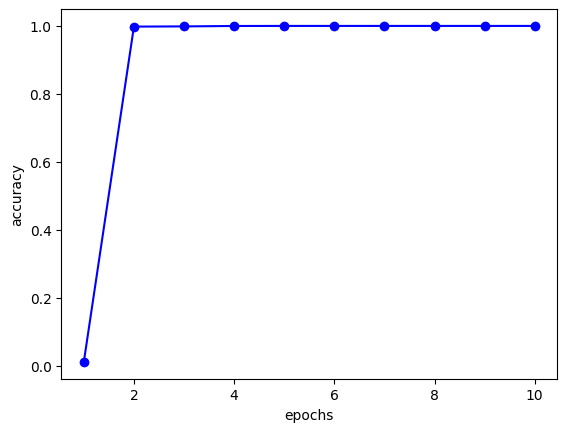

In [61]:
import matplotlib.pyplot as plt

plt.plot(np.arange(1,max_epoch+1), acc_list, marker='o', color='blue')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.yticks(np.arange(0.0, 1.2, 0.2))
plt.show()